In [110]:
# %load first_cell.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in 5 million rows and create 2 new features

In [111]:
data = pd.read_csv('/data/taxi_fare/train.csv', nrows = 5_000_000).drop(columns = 'key')

# Remove na
data = data.dropna()

# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009041,0.002701
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.070701,0.036780
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.010708,0.008504
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.024949,0.004437
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.015754,0.011440


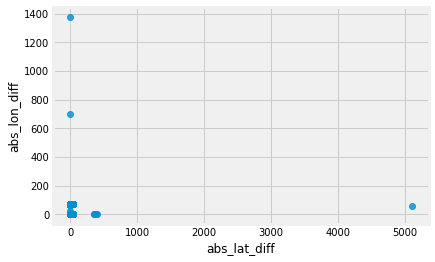

In [71]:
sns.regplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False, data = data.sample(100000))

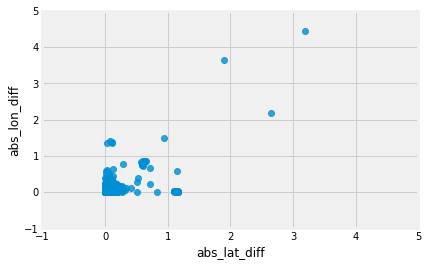

In [72]:
sns.regplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False, data = data.sample(100000))
plt.xlim((-1, 5)); plt.ylim((-1, 5));

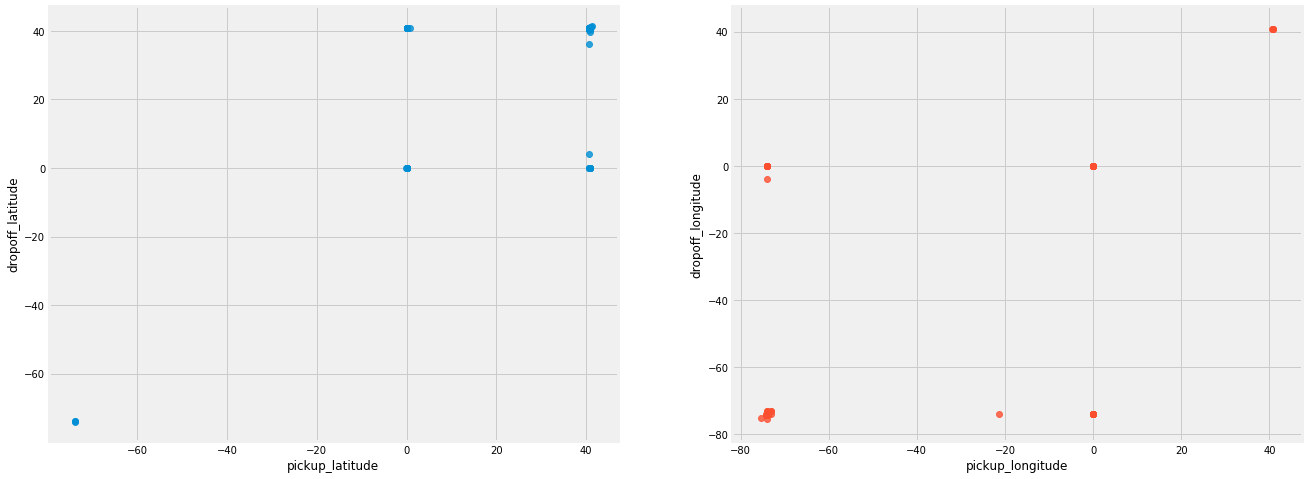

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes = axes.flatten()

sns.regplot('pickup_latitude', 'dropoff_latitude', fit_reg = False, data = data.sample(10000), ax = axes[0]);
sns.regplot('pickup_longitude', 'dropoff_longitude', fit_reg = False, data = data.sample(10000), ax = axes[1]);

In [74]:
data[['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']].describe()

,pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude
count,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06
mean,-7.250681e+01,-7.250652e+01,3.991976e+01,3.991725e+01
std,1.280962e+01,1.284777e+01,8.963488e+00,9.486767e+00
min,-3.426609e+03,-3.412653e+03,-3.488080e+03,-3.488080e+03
25%,-7.399206e+01,-7.399139e+01,4.073491e+01,4.073404e+01
50%,-7.398181e+01,-7.398016e+01,4.075263e+01,4.075315e+01
75%,-7.396711e+01,-7.396367e+01,4.076712e+01,4.076811e+01
max,3.439426e+03,3.457622e+03,3.310364e+03,3.345917e+03


# Remove outliers based on latitude and longitude

In [75]:
data = data[(data['pickup_longitude'] > -75) & (data['dropoff_longitude'] < -70)]
data = data[(data['pickup_latitude'] > 40) & (data['dropoff_latitude'] < 45)]

In [121]:
# Filter outliers
data = data[data['abs_lat_diff'] < 1]
data = data[data['abs_lon_diff'] < 1]

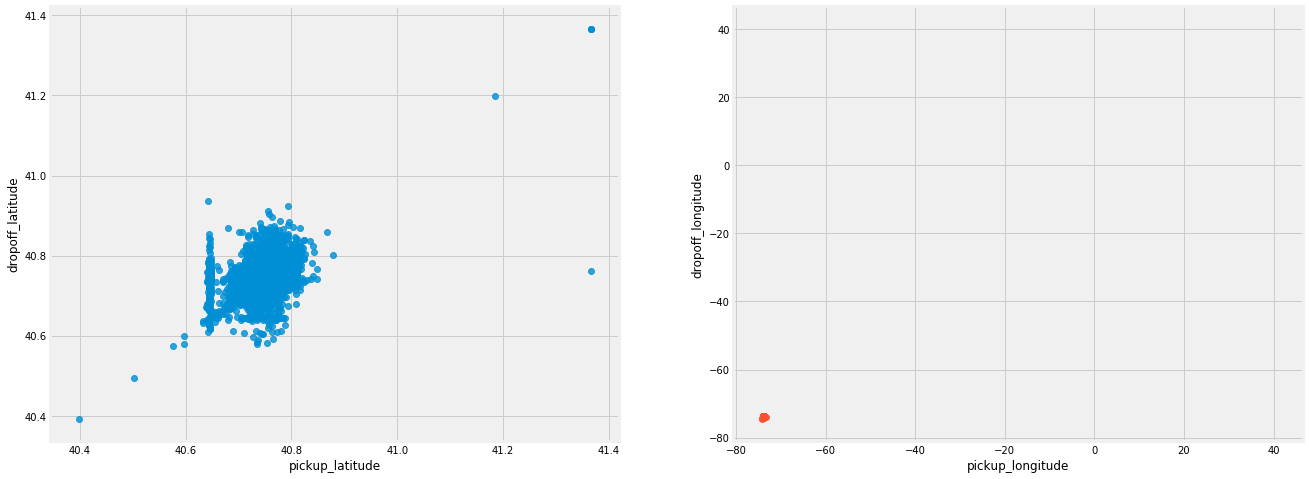

In [77]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes = axes.flatten()

sns.regplot('pickup_latitude', 'dropoff_latitude', fit_reg = False, data = data.sample(10000), ax = axes[0]);
sns.regplot('pickup_longitude', 'dropoff_longitude', fit_reg = False, data = data.sample(10000), ax = axes[1]);

In [112]:
test = pd.read_csv('/data/taxi_fare/test.csv')

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

test_id = list(test.pop('key'))

In [79]:
test[['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'abs_lat_diff', 'abs_lon_diff']].describe()

,pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude,abs_lat_diff,abs_lon_diff
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,-73.973657,40.751041,40.751743,0.022133,0.023348
std,0.042774,0.039072,0.033541,0.035435,0.025589,0.036719
min,-74.252193,-74.263242,40.573143,40.568973,0.000000,0.000000
25%,-73.992501,-73.991247,40.736125,40.735254,0.007279,0.006354
50%,-73.982326,-73.980015,40.753051,40.754065,0.014715,0.013123
75%,-73.968013,-73.964059,40.767113,40.768757,0.028261,0.024557
max,-72.986532,-72.990963,41.709555,41.696683,0.633213,0.849168


# Calculate Distance between points using Haversine distance

In [113]:
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R * c
    return km

In [114]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

In [115]:
test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

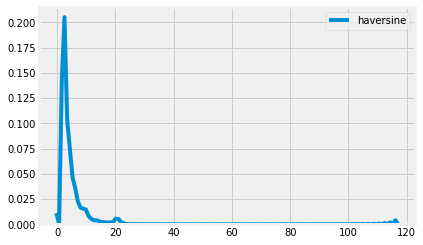

In [83]:
sns.kdeplot(data['haversine']);

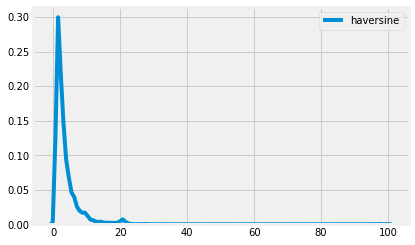

In [84]:
sns.kdeplot(test['haversine']);

In [53]:
data = data[data['fare_amount'] > 0]

# First Model

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set

In [123]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      random_state = 40, test_size = 1_000_000)

### Use Simple Features

In [124]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 'abs_lon_diff coef:', round(lr.coef_[1], 4))

Intercept 5.2772
abs_lat_diff coef:  111.4904 abs_lon_diff coef: 166.2069


In both cases, the coefficient is positive, indicating a larger absolute difference corresponds to a larger fare according to the model. The `intercept` indicates the fare that would be predicted if there is no latitude or longitude difference.

#### Score Model

Use the validation set for assessing the model. We'll use two metrics:

* Root mean squared error: the metric used by the competition
* Mean absolute percentage error: the average percentage error of the predictions

In [57]:
data[data['fare_amount'] == 0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,haversine


In [125]:
from sklearn.metrics import mean_squared_error

def mape(y_true, y_pred):
    """Mean absolute percentage error"""
    # Calculate absolute percentage error
    ape = abs((y_true - y_pred) / y_true)
    
    # Account for y values of 0
    ape[ape == np.inf] = 0
    ape[ape == -np.inf] = 0
    
    return 100 * np.mean(ape)

In [126]:
valid_preds = lr.predict(X_valid[['abs_lat_diff', 'abs_lon_diff']])

rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mape_ = mape(y_valid, valid_preds)

print('Root mean squared error: ', round(rmse, 4))
print('Mean absolute percentage error: ', round(mape_, 4))

Root mean squared error:  5.9001
Mean absolute percentage error:  30.4613


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [127]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr.csv', index = False)

## Use Non-Linear Model

In [129]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 25, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
random_forest.fit(X_train[['abs_lat_diff', 'abs_lon_diff']], y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [130]:
valid_preds = random_forest.predict(X_valid[['abs_lat_diff', 'abs_lon_diff']])

rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mape_ = mape(y_valid, valid_preds)

print('Root mean squared error: ', round(rmse, 4))
print('Mean absolute percentage error: ', round(mape_, 4))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s


Root mean squared error:  4.9804
Mean absolute percentage error:  24.7958


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.6s finished
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [131]:
preds = random_forest.predict(test[['abs_lat_diff', 'abs_lon_diff']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf.csv', index = False)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


# More Features

In [133]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 100, max_depth = 20,
                                           n_jobs = -1, verbose = 1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    valid_preds = model.predict(X_valid[features])
    rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
    mape_ = mape(y_valid, valid_preds)
    
    print('Root mean squared error: ', round(rmse, 4))
    print('Mean absolute percentage error: ', round(mape_, 4))
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False)
    
    return sub, feature_importances

In [134]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count'])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.5min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.7s finished
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Root mean squared error:  4.866
Mean absolute percentage error:  24.4053


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [135]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.5s finished
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Root mean squared error:  4.2771
Mean absolute percentage error:  23.0186


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [136]:
sub.to_csv('sub_rf_8_features.csv', index = False)

In [137]:
fi

,feature,importance
2,haversine,0.833396
7,dropoff_longitude,0.045532
1,abs_lon_diff,0.031536
6,dropoff_latitude,0.027765
5,pickup_longitude,0.025412
4,pickup_latitude,0.020647
0,abs_lat_diff,0.013098
3,passenger_count,0.002614


## Extract Datetime Information

In [144]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    
    targ_pre = re.sub('[Dd]ate', '', date_col)
    targ_pre = re.sub('[Tt]ime', '', targ_pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if time:
        # Add fractional time of day
        df[targ_pre + 'FractimeDay'] = (df[targ_pre + 'Hour'] / 24) + (df[targ_pre + 'Minute'] / 60 / 24) + (df[targ_pre + 'Second'] / 60 / 60 / 24)
        
        # Add fractional time of week
        df[targ_pre + 'FractimeWeek'] = ((df[targ_pre + 'Dayofweek'] * 24) + (df[targ_pre + 'FractimeDay'] * 24)) / (7 * 24)
    
    # Add seconds since start of reference
    df[targ_pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [145]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, time = True)
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,haversine,...,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.009041,0.002701,1.031896,...,25,15,0,166,17,26,21,0.726632,0.103805,3.454076e+09
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.070701,0.036780,8.459418,...,1,5,1,5,16,52,16,0.702963,0.243280,3.471699e+09
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.010708,0.008504,1.391052,...,33,18,3,230,0,35,0,0.024306,0.432044,3.522616e+09
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.024949,0.004437,2.802346,...,16,21,5,112,4,30,42,0.187986,0.741141,3.543971e+09
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.015754,0.011440,2.001353,...,10,9,1,68,7,51,0,0.327083,0.189583,3.477110e+09


In [150]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, time = True)
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,haversine,pickup_Year,...,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,0.019970,0.008110,2.325812,2015,...,5,27,1,27,13,8,24,0.547500,0.221071,3.631353e+09
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,0.019817,0.012024,2.428018,2015,...,5,27,1,27,13,8,24,0.547500,0.221071,3.631353e+09
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.005121,0.002870,0.619308,2011,...,40,8,5,281,11,53,44,0.495648,0.785093,3.527064e+09
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,0.016172,0.009288,1.963187,2012,...,48,1,5,336,21,12,12,0.883472,0.840496,3.563385e+09
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,0.045348,0.022519,5.393220,2012,...,48,1,5,336,21,12,12,0.883472,0.840496,3.563385e+09


In [151]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      random_state = 40, test_size = 1_000_000)

In [152]:
time_features = [x for x in test if 'pickup' in x]
time_features.remove('pickup_datetime')
time_features.remove('pickup_longitude')
time_features.remove('pickup_latitude')
time_features

['pickup_Year',
 'pickup_Month',
 'pickup_Week',
 'pickup_Day',
 'pickup_Dayofweek',
 'pickup_Dayofyear',
 'pickup_Hour',
 'pickup_Minute',
 'pickup_Second',
 'pickup_FractimeDay',
 'pickup_FractimeWeek',
 'pickup_Elapsed']

In [153]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'] + time_features)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 53.2min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.9s finished
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Root mean squared error:  3.993
Mean absolute percentage error:  20.4494


In [156]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [154]:
sub.to_csv('sub_rf_time.csv', index = False)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [ ]:
data.head()

In [ ]:
train = data.iloc[:, 5:]

labels = np.array(data['fare_amount']).reshape((-1, ))
lr.fit(train, labels)

In [ ]:
lr.score(train, labels)

In [ ]:
train.head()

In [ ]:
test = test_.iloc[:, 4:]
test = test[train.columns]
test.head()

In [ ]:
[x for x in train if x not in test]

In [ ]:
corrs = data.sample(1_000_000).corr()

In [ ]:
corrs.sort_values('fare_amount').tail()

In [ ]:
corrs.sort_values('fare_amount').head()

In [ ]:
data.columns

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

subset = data[['abs_lat_diff', 'abs_lon_diff', 'haversine']]

X_train, X_valid, y_train, y_valid = train_test_split(subset, labels, test_size = 0.4)

test_subset = test[['abs_lat_diff', 'abs_lon_diff']]

valid_preds = lr.fit(X_train, y_train).predict(X_valid)
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_valid, valid_preds))}')

In [ ]:
test['abs_lat_diff'].describe()

In [ ]:
lr.intercept_

In [ ]:
lr.coef_

In [ ]:
preds = lr.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr.csv', index = False)

In [ ]:
plt.hist(preds)

In [ ]:
!cd "~/git/neural-networks/taxi_fare/" && kaggle competitions submit -f sub_lr.csv -m "Corrected Linear Regression" new-york-city-taxi-fare-prediction

In [155]:
!kaggle competitions submissions new-york-city-taxi-fare-prediction

fileName         date                 description                  status    publicScore        privateScore  
---------------  -------------------  ---------------------------  --------  -----------------  ------------  
sub_rf_time.csv  2018-09-05 19:45:00  Random Forest with time      complete  3.09664            None          
sub_rf.csv       2018-09-05 15:34:41  Random Forest                complete  4.07869            None          
sub_lr.csv       2018-09-05 15:05:01  Corrected Linear Regression  complete  5.73051            None          
sub_lr.csv       2018-09-05 15:02:59  Corrected Linear Regression  complete  5.73876            None          
sub_lr.csv       2018-09-05 14:56:29  Corrected Linear Regression  complete  5.74396            None          
sub_lr.csv       2018-09-05 01:12:12  Corrected Linear Regression  complete  5.14856            None          
sub_lr.csv       2018-09-05 01:09:54  Corrected Linear Regression  complete  15034142279.28590  None          
s

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 25, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
random_forest.fit(train, labels)

In [ ]:
preds = random_forest.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_random_forest.csv', index = False)

In [ ]:

fldname = 'pickup_datetime'
targ_pre = re.sub('[Dd]ate$', '', fldname)

In [ ]:
targ_pre